# Notebook 3: Data Processing and Clustering with `scanpy`

**Tutor:** Anthony Christidis
**Time:** 45 minutes

---

Welcome to the computational analysis part of the workshop! Before we dive into advanced spatial statistics, we must first process our raw gene expression data to identify meaningful biological groupings. This is a fundamental step in almost any single-cell or spatial analysis.

In this notebook, we'll use `scanpy` to perform a standard clustering analysis and `matplotlib` for robust QC plotting. We will first learn the workflow in detail on a **10x Visium** dataset, and then apply the same principles to prepare our **Xenium** data for the next notebook.

**Goals:**
1.  Perform a comprehensive Quality Control (QC) workflow on Visium data.
2.  Run a standard unsupervised clustering workflow (`scanpy`).
3.  Visualize the final spot clusters on the tissue, confirming that our analysis reveals underlying biology.
4.  Apply a streamlined workflow to process our Xenium data.

### Setup

First, we'll import our libraries and load the Visium Glioblastoma dataset.

In [1]:
# for cleaner output

import warnings
warnings.filterwarnings("ignore")

In [2]:
import spatialdata as sd
import spatialdata_plot as sdp
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from pathlib import Path

# Define the path to our data directory
# Note: This path is relative to the repository's root directory
_DATA_DIR_PATH = Path("../data/")
_VISIUM_PATH = _DATA_DIR_PATH / "visium_glioblastoma_subset.zarr"
_XENIUM_PATH = _DATA_DIR_PATH / "xenium_lung_cancer_subset.zarr"

# Print versions for reproducibility
for p in [sd, sdp, sc]:
    print(f"{p.__name__}: {p.__version__}")

spatialdata: 0.5.0
spatialdata_plot: 0.2.13
scanpy: 1.11.5


In [3]:
sdata_visium = sd.read_zarr(_VISIUM_PATH)

# adata_visium = sdata_visium.tables["table"]

sdata_visium

SpatialData object, with associated Zarr store: /Users/tim.treis/Documents/GitHub/Spatial-Workshop/data/visium_glioblastoma_subset.zarr
├── Images
│     ├── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_hires_image': DataArray[cyx] (3, 2000, 1744)
│     └── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_lowres_image': DataArray[cyx] (3, 600, 523)
├── Shapes
│     └── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma': GeoDataFrame shape: (5756, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (5756, 18085)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_hires_image (Images), CytAssist_FFPE_Protein_Expression_Human_Glioblastoma (Shapes)
    ▸ 'downscaled_lowres', with elements:
        CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_lowres_image (Images), CytAssist_FFPE_Protein_Expression_Human_Glioblastoma (Shapes)
    ▸ 'global', with elements:
        CytAssist_FFPE_Protein_Expr

### Part 1: Visium Analysis - Spatial Quality Control

For spot-based data like Visium, visualizing QC metrics spatially is a critical first step. It can reveal technical issues like tissue detachment or slide artifacts.

First, we calculate standard QC metrics, such as the number of genes detected per spot (`n_genes_by_counts`) and the total number of transcripts per spot (`total_counts`).

In [4]:
sc.pp.calculate_qc_metrics(sdata_visium.tables["table"], percent_top=(20, 50), inplace=True)

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Converting 5756 shapes to visium_hex.                                                                     
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Converting 5756 shapes to visium_hex.                                                                     


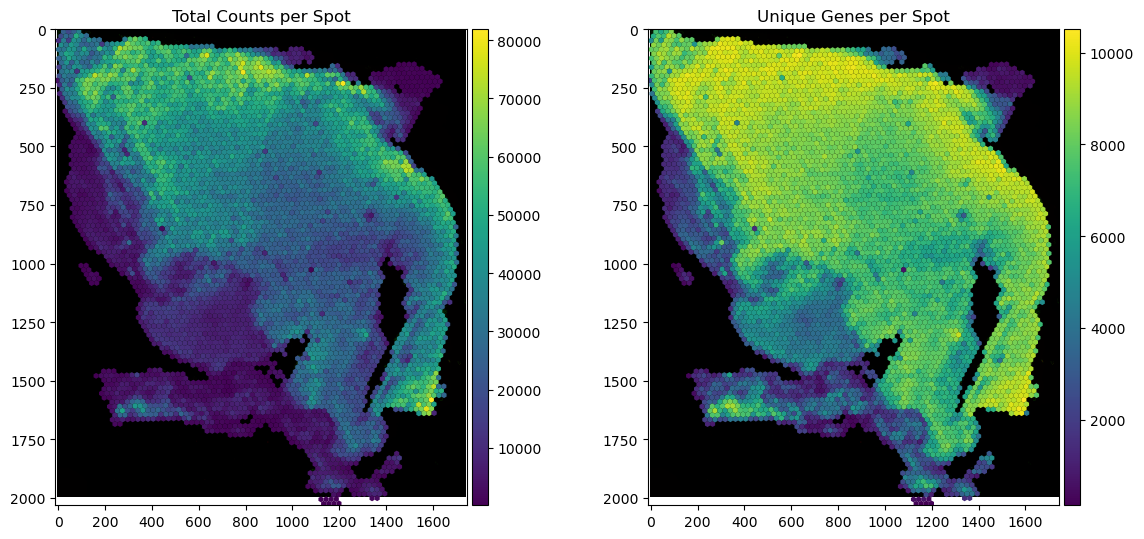

In [5]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 5.5))

(
    sdata_visium
    .pl.render_images()
    .pl.render_shapes(color="total_counts", shape="visium_hex")
    .pl.show("downscaled_hires", ax=axs[0], title="Total Counts per Spot")
)
(
    sdata_visium
    .pl.render_images()
    .pl.render_shapes(color="n_genes_by_counts", shape="visium_hex")
    .pl.show("downscaled_hires", ax=axs[1], title="Unique Genes per Spot")
)

fig.tight_layout()

Now, we will create spatial scatter plots to visualize these QC metrics. This allows us to see if low-quality spots are concentrated in a specific area, which might indicate a problem with the tissue section.

In [6]:
# Get the spatial coordinates directly from the AnnData object
# coords = adata_visium.obsm['spatial']
# x_coords = coords[:, 0]
# y_coords = coords[:, 1]

# Create the two-panel plot
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Total counts
# scatter1 = axes[0].scatter(x_coords, y_coords, c=adata_visium.obs['total_counts'], 
#                           cmap='viridis', s=25, alpha=0.8)
# axes[0].set_title('Total Counts per Spot')
# axes[0].set_aspect('equal')
# plt.colorbar(scatter1, ax=axes[0])

# Plot 2: Number of genes
# scatter2 = axes[1].scatter(x_coords, y_coords, c=adata_visium.obs['n_genes_by_counts'], 
#                           cmap='viridis', s=25, alpha=0.8)
# axes[1].set_title('Unique Genes per Spot')
# axes[1].set_aspect('equal')
# plt.colorbar(scatter2, ax=axes[1])

# plt.tight_layout()
# plt.show()

These plots are essential. We can see clear spatial patterns in both the total counts and the number of genes, which likely correspond to different biological regions within the glioblastoma tissue.

### Part 2: Visium Analysis - The `scanpy` Clustering Workflow

Based on our QC, let's filter out the lowest-quality spots and then run the standard `scanpy` workflow to find transcriptionally distinct groups of spots. Each step is broken down into its own cell for clarity.

#### Step 2.1: Filtering
We remove spots with very few counts and genes that are detected in very few spots. This reduces noise in our data.

In [7]:
print(f"Spots before filtering: {sdata_visium.tables['table'].n_obs}")
sc.pp.filter_cells(sdata_visium.tables["table"], min_counts=500)
sc.pp.filter_genes(sdata_visium.tables["table"], min_cells=10)
print(f"Spots after filtering: {sdata_visium.tables['table'].n_obs}")

Spots before filtering: 5756
Spots after filtering: 5734


#### Step 2.2: Normalization and Log-Transformation
This step corrects for differences in sequencing depth between spots, ensuring that we are comparing their relative gene expression profiles.

In [8]:
sc.pp.normalize_total(sdata_visium.tables["table"], inplace=True)
sc.pp.log1p(sdata_visium.tables["table"])

#### Step 2.3: Finding Highly Variable Genes (HVGs)
We don't need to use all ~18,000 genes for clustering. We can identify the genes that show the most biological variability across the tissue and focus our analysis on them. This reduces computational time and often improves results.

In [9]:
sc.pp.highly_variable_genes(sdata_visium.tables["table"])

#### Step 2.4: Principal Component Analysis (PCA)
PCA is a dimensionality reduction technique. We use it to summarize the main axes of variation in our highly variable genes into a smaller number of principal components (PCs).

In [10]:
sc.pp.pca(sdata_visium.tables["table"], use_highly_variable=True)

#### Step 2.5: Neighborhood Graph and Leiden Clustering
Next, we build a graph where each spot is a node, and nodes are connected if they are similar to each other in the PCA space. The Leiden algorithm then walks through this graph to find communities of spots that are highly interconnected. These communities are our cell type clusters.

In [11]:
sc.pp.neighbors(sdata_visium.tables["table"])
sc.tl.leiden(sdata_visium.tables["table"], key_added="clusters")

#### Step 2.6: UMAP for Visualization
Finally, we compute a UMAP (Uniform Manifold Approximation and Projection). This takes our high-dimensional neighborhood graph and creates a 2D representation of it, which is useful for visualizing the relationships between our clusters.

In [12]:
sc.tl.umap(sdata_visium.tables["table"])

### Part 3: Visualizing the Visium Results
Let's visualize the clusters we found, both in the abstract UMAP space and back on the tissue.

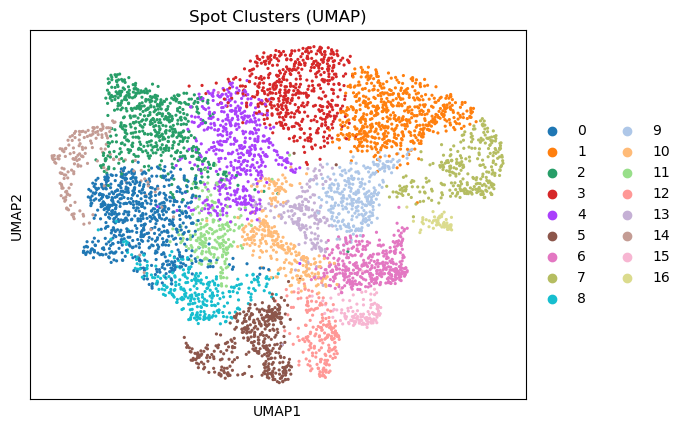

In [13]:
sc.pl.umap(sdata_visium.tables["table"], color="clusters", title="Spot Clusters (UMAP)")

INFO     Converting 5734 shapes to visium_hex.                                                                     


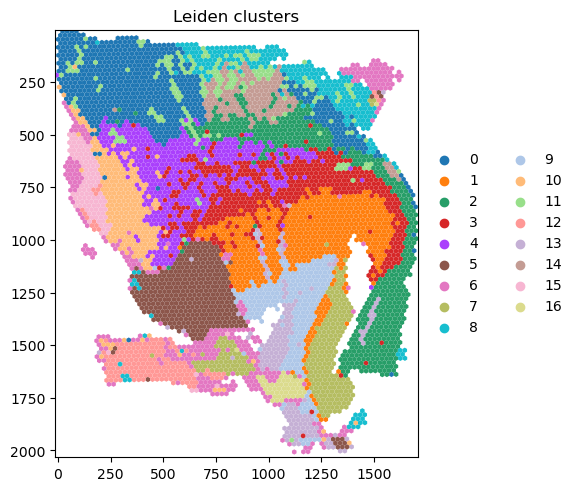

In [26]:
(
    sdata_visium
    .pl.render_shapes(color="clusters", shape="visium_hex")
    .pl.show("downscaled_hires", title="Leiden clusters")
)

In [15]:
# To plot spatially, we'll use our robust matplotlib method again.

# Get coordinates and cluster info
# coords = adata_visium.obsm['spatial']
# x_coords = coords[:, 0]
# y_coords = coords[:, 1]
# cluster_codes = adata_visium.obs['clusters'].astype('category').cat.codes

# Create the plot
# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# scatter = ax.scatter(x_coords, y_coords, c=cluster_codes, 
#                     cmap='tab10', s=25, alpha=0.8)
# ax.set_title('Spot Clusters (Spatial View)')
# ax.set_aspect('equal')

# Add a legend
# unique_clusters = adata_visium.obs['clusters'].unique()
# colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
# legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], 
#                          markersize=8, label=f'Cluster {cluster}') 
#                   for i, cluster in enumerate(unique_clusters)]
# ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.tight_layout()
# plt.show()

### Optional: Interactive QC Visualization with `napari`

While static plots are great for a quick overview, we can use `napari` for a more dynamic exploration of our QC metrics. This allows us to zoom in on specific areas and see how metrics vary across the tissue.

*(Instructor Note: I will run this live. For those using the workshop's Docker container, this requires the graphics server setup detailed in the README. You can simply watch my screen for this brief demonstration.)*

In [16]:
import napari_spatialdata as nsd

# We launch napari with our sdata_visium object.
# The QC metrics we calculated are already in its associated table.
# viewer = nsd.Interactive(sdata_visium)

# In the Napari window that opens, you can now:
# 1. Add the hires_image and the shapes layer.
# 2. In the annotation panel on the right, under "Observation", select 'total_counts'
#    or 'n_genes_by_counts' to color the spots by these QC metrics.

### Part 4: Preparing the Xenium Data for the Next Notebook

Now that we've mastered the workflow, we will apply the same steps to our Xenium data. We will break it down into cells and include the QC histograms and the final UMAP plot, as these are known to work.

In [17]:
print("--- Processing Xenium Data ---")

# 1. Load Data
sdata_xenium = sd.read_zarr(_XENIUM_PATH)

# adata_xenium = sdata_xenium.tables["table"].copy()

sdata_xenium

--- Processing Xenium Data ---


SpatialData object, with associated Zarr store: /Users/tim.treis/Documents/GitHub/Spatial-Workshop/data/xenium_lung_cancer_subset.zarr
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 5636, 1448), (3, 2818, 724), (3, 1409, 362), (3, 704, 181), (3, 352, 90)
│     └── 'morphology_focus': DataTree[cyx] (1, 17098, 51187), (1, 8549, 25593), (1, 4274, 12796), (1, 2137, 6398), (1, 1068, 3199)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
│     └── 'nucleus_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (162254, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (162254, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (156628, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (162254, 377)
with 

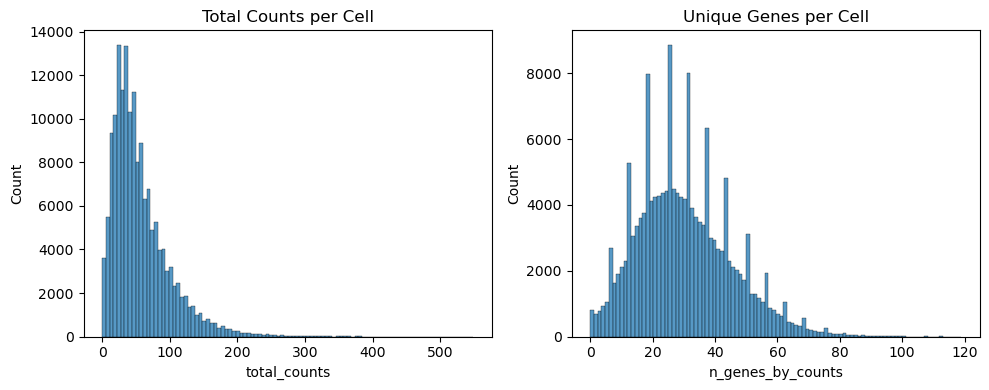

In [18]:
import seaborn as sns

# 2. Calculate and Visualize QC Metrics
sc.pp.calculate_qc_metrics(sdata_xenium.tables["table"], percent_top=(20, 50), inplace=True)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(sdata_xenium.tables["table"].obs["total_counts"], kde=False, bins=100, ax=axs[0])
axs[0].set_title("Total Counts per Cell")
sns.histplot(sdata_xenium.tables["table"].obs["n_genes_by_counts"], kde=False, bins=100, ax=axs[1])
axs[1].set_title("Unique Genes per Cell")
plt.tight_layout()
plt.show()

In [19]:
# 3. Filter the data
print(f"Cells before filtering: {sdata_xenium.tables['table'].n_obs}")
sc.pp.filter_cells(sdata_xenium.tables["table"], min_counts=50)
sc.pp.filter_genes(sdata_xenium.tables["table"], min_cells=10)
print(f"Cells after filtering: {sdata_xenium.tables['table'].n_obs}")

Cells before filtering: 162254
Cells after filtering: 74052


In [20]:
# 4. Run the rest of the workflow
sc.pp.normalize_total(sdata_xenium.tables["table"])
sc.pp.log1p(sdata_xenium.tables["table"])
sc.pp.highly_variable_genes(sdata_xenium.tables["table"], n_top_genes=2000, flavor='seurat')
sc.pp.pca(sdata_xenium.tables["table"], use_highly_variable=True)
sc.pp.neighbors(sdata_xenium.tables["table"])
sc.tl.leiden(sdata_xenium.tables["table"], key_added="clusters")
sc.tl.umap(sdata_xenium.tables["table"])

Xenium data processed. Found 14 clusters.


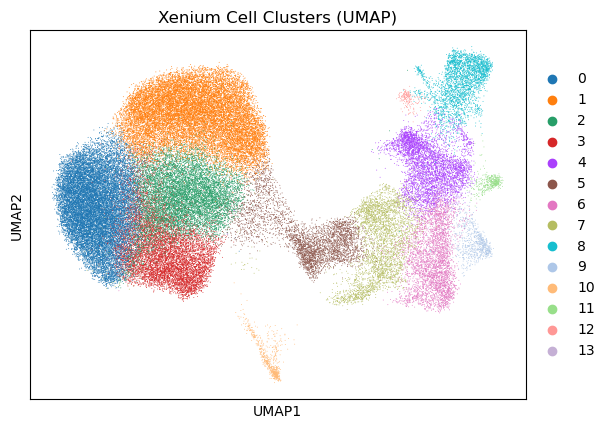

In [21]:
# 5. Visualize the Xenium UMAP
print(f"Xenium data processed. Found {len(sdata_xenium.tables['table'].obs['clusters'].unique())} clusters.")
sc.pl.umap(sdata_xenium.tables["table"], color="clusters", title="Xenium Cell Clusters (UMAP)")

In [22]:
sdata_xenium

SpatialData object, with associated Zarr store: /Users/tim.treis/Documents/GitHub/Spatial-Workshop/data/xenium_lung_cancer_subset.zarr
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 5636, 1448), (3, 2818, 724), (3, 1409, 362), (3, 704, 181), (3, 352, 90)
│     └── 'morphology_focus': DataTree[cyx] (1, 17098, 51187), (1, 8549, 25593), (1, 4274, 12796), (1, 2137, 6398), (1, 1068, 3199)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
│     └── 'nucleus_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (162254, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (162254, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (156628, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (74052, 377)
with c

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' to disable this    
         behaviour.                                                                                                


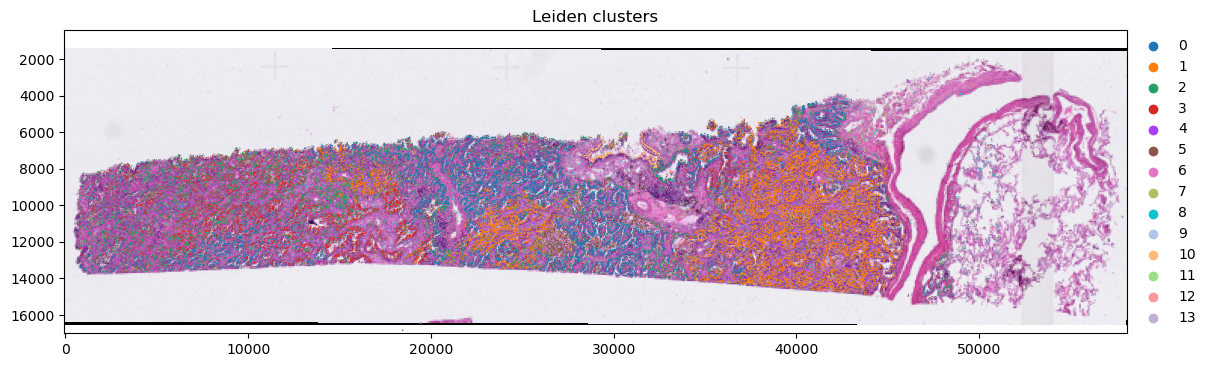

In [23]:
(
    sdata_xenium
    .pl.render_images("he_image")
    .pl.render_shapes("cell_circles", color="clusters", fill_alpha=1)
    .pl.show(title="Leiden clusters", figsize=(12, 4))
)

In [24]:
sdata_xenium

SpatialData object, with associated Zarr store: /Users/tim.treis/Documents/GitHub/Spatial-Workshop/data/xenium_lung_cancer_subset.zarr
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 5636, 1448), (3, 2818, 724), (3, 1409, 362), (3, 704, 181), (3, 352, 90)
│     └── 'morphology_focus': DataTree[cyx] (1, 17098, 51187), (1, 8549, 25593), (1, 4274, 12796), (1, 2137, 6398), (1, 1068, 3199)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
│     └── 'nucleus_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (162254, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (162254, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (156628, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (74052, 377)
with c

In [25]:
# 6. Save the processed AnnData object
import os
os.makedirs(_DATA_DIR_PATH / "processed", exist_ok=True)

print("Saving processed Xenium SpatialData object...")
sdata_xenium.write(_DATA_DIR_PATH / "processed" / "sdata_xenium_processed.zarr", overwrite=True)
print("Done. We are ready for Notebook 4.")

Saving processed Xenium SpatialData object...
INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside ../data/processed/sdata_xenium_processed.zarr). Please see the documentation of         
         `is_self_contained()` to understand the implications of working with SpatialData objects that are not     
         self-contained.                                                                                           
INFO     The Zarr backing store has been changed from ../data/xenium_lung_cancer_subset.zarr the new file path:    
         ../data/processed/sdata_xenium_processed.zarr                                                             
Done. We are ready for Notebook 4.


<div style="border: 1px solid #4CAF50; border-left-width: 15px; padding: 10px; background-color: #F0FFF0; color: black;">
    <strong>Summary:</strong>
    <p>This concludes the third part of our workshop. We've learned how to perform and visualise basic analysis steps on the expression matrices.</p>
</div>